In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
%cd /content/gdrive/MyDrive/Kaggle

/content/gdrive/MyDrive/Kaggle


In [3]:
# importing the required packages
import numpy as np
import matplotlib.pyplot as plt
import os, glob
import pickle
import pandas as pd
import csv
import cv2 as cv
import imutils
from PIL import Image
from skimage import exposure, feature, transform
%matplotlib inline

# classification required packages
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import classification_report
from sklearn.externals import joblib
from sklearn.model_selection import GridSearchCV

import PIL
from PIL import ImageFont
from PIL import Image
from PIL import ImageDraw

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [4]:
data_dir = '/content/gdrive/MyDrive/Kaggle'
test_dir = '/content/gdrive/MyDrive/Kaggle/Test'
train_dir = '/content/gdrive/MyDrive/Kaggle/Train'

In [5]:
train = pd.read_csv(os.path.join(data_dir, 'Train.csv'))
train.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,27,26,5,5,22,20,20,Train/20/00020_00000_00000.png
1,28,27,5,6,23,22,20,Train/20/00020_00000_00001.png
2,29,26,6,5,24,21,20,Train/20/00020_00000_00002.png
3,28,27,5,6,23,22,20,Train/20/00020_00000_00003.png
4,28,26,5,5,23,21,20,Train/20/00020_00000_00004.png


In [6]:
test =  pd.read_csv(os.path.join(data_dir, 'Test.csv'))
test.head()

,Width,Height,Roi.X1,Roi.Y1,Roi.X2,Roi.Y2,ClassId,Path
0,53,54,6,5,48,49,16,Test/00000.png
1,42,45,5,5,36,40,1,Test/00001.png
2,48,52,6,6,43,47,38,Test/00002.png
3,27,29,5,5,22,24,33,Test/00003.png
4,60,57,5,5,55,52,11,Test/00004.png


# load training images

In [7]:
def load_image(train_data, data_dir):
  data = []
  labels = []
  for row in train_data.iterrows():
    if row[0] % 1000 == 0:
      print('Load image', row[0])
    image_path = row[1]['Path']
    classId = row[1]['ClassId']
    
    image = cv.imread(os.path.join(data_dir, image_path))

    data.append(image)
    labels.append(classId)
  return data, labels

In [8]:
if os.path.isfile("Image_n_Labels/trainImages.npy") &  os.path.isfile("Image_n_Labels/trainLabels.npy") :
    X = np.load("Image_n_Labels/trainImages.npy", allow_pickle=True)
    y = np.load("Image_n_Labels/trainLabels.npy", allow_pickle=True)
    print("[INFO] Training images and labels are loaded in variables ==> X,y")
    print("[INFO] Number of training Images {} \nNumber of Labels {}".format(len(X), len(y)))
else:
    # training images and labels
    trainImages, trainLabels = load_image(train, data_dir)
    np.save("Image_n_Labels/trainImages.npy",trainImages)
    np.save("Image_n_Labels/trainLabels.npy",trainLabels)
    print("[INFO] training images and labels are read from the dataset directory")
    print("[INFO] training images saved to Image_n_Labels/trainingImages.npy for further use")
    print("[INFO] training labels saved to Image_n_Labels/trainingLabels.npy for further use")

[INFO] Training images and labels are loaded in variables ==> X,y
[INFO] Number of training Images 39209 
Number of Labels 39209


# load test images

In [9]:
if os.path.isfile("Image_n_Labels/testImages.npy") & os.path.isfile("Image_n_Labels/testLabels.npy") :
    X_test = np.load("Image_n_Labels/testImages.npy", allow_pickle=True)
    y_test = np.load("Image_n_Labels/testLabels.npy", allow_pickle=True)
    print("[INFO] Training images and labels are loaded in variables ==> X_test,y_test")
    print("[INFO] Number of training Images {} \nNumber of Labels {}".format(len(X_test), len(y_test)))
else:    
    # training images and labels
    testImages, testLabels = load_image(test, data_dir)
    np.save("Image_n_Labels/testImages.npy", testImages)
    np.save("Image_n_Labels/testLabels.npy", testLabels)
    print("[INFO] testing images and labels are read from the dataset directory")
    print("[INFO] testing images saved to Image_n_Labels/testImages.npy for further use")
    print("[INFO] testing labels saved to Image_n_Labels/testLabels.npy for further use")

[INFO] Training images and labels are loaded in variables ==> X_test,y_test
[INFO] Number of training Images 12630 
Number of Labels 12630


# simple test on single image for HoG features

In [10]:
def showimg_n_hog(grayimg,hogImage):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)

    ax1.axis('off')
    ax1.imshow(grayimg)
    ax1.set_title('Input image')
    ax1.set_adjustable('box')

    ax2.axis('off')
    ax2.imshow(hogImage, cmap=plt.cm.gray)
    ax2.set_title('Histogram of Oriented Gradients')
    ax1.set_adjustable('box')
    plt.show()

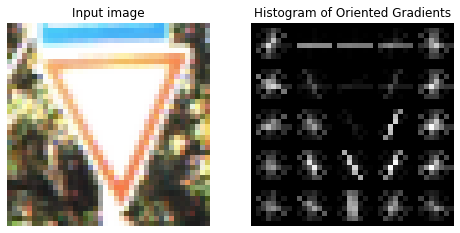

Số các đặc trưng HoG trích xuất từ ảnh:  576


In [11]:
n = np.random.randint(0,len(X))
i1 = X[n]
grayim = cv.cvtColor(i1, cv.COLOR_BGR2GRAY)
gI1 = transform.resize(grayim,(40,40))
(H, hogImage) = feature.hog(gI1, orientations=9, pixels_per_cell=(8,8),
                            cells_per_block=(2, 2), transform_sqrt=True, visualize=True)
hogImage = exposure.rescale_intensity(hogImage, out_range=(0, 255)).astype("uint8")

showimg_n_hog(transform.resize(cv.cvtColor(i1, cv.COLOR_BGR2RGB), (40, 40)), hogImage)
print("Số các đặc trưng HoG trích xuất từ ảnh: ", len(H))

# Extract HoG features over all training images

In [13]:
if os.path.isfile("HoGFeatures/HoGfeatures.npy") & os.path.isfile("HoGFeatures/HoGvisualize.npy") :
    print("[INFO] loading from file ... ")
    hogfeat = np.load("HoGFeatures/HoGfeatures.npy", allow_pickle=True)
    hogviz = np.load("HoGFeatures/HoGvisualize.npy", allow_pickle=True)
    
    print("HoG features are loaded from HoGfeatures.npy to variable ==> hogfeat")
    print("HoG visualizations are loaded from HoGvisualize.npy to variable ==> hogviz")
else:
    print("[INFO] HoGfeatures.npy does not found")
    Hviz = []
    Hfeat = []
    for i in range(0, len(X)):
        # show an update every 1,000 images
        if i > 0 and i % 1000 == 0:
            print("[INFO] processed {}/{}".format(i, len(X)))
        # if i > 0:
        #     print("[INFO] processed {}/{}".format(i, len(X)))
        I = X[i]
        #grayim = cv.cvtColor(I, cv.COLOR_RGB2GRAY)
        #grayim = rgb2gray(I)
        grayim = cv.cvtColor(I, cv.COLOR_BGR2GRAY)
        grayim = transform.resize(grayim,(40,40))

        (H_4x4, hogImage) = feature.hog(grayim, orientations=9, pixels_per_cell=(4, 4),
            cells_per_block=(2, 2), transform_sqrt=True, visualize=True)
        hogImage = exposure.rescale_intensity(hogImage, out_range=(0, 255)).astype("uint8")
        Hviz.append(hogImage)
        Hfeat.append(H_4x4)
        # save the features using numpy save with .npy extention 
        # which reduced the storage space by 4times compared to pickle
    np.save("HoGFeatures/HoGfeatures.npy", Hfeat)
    np.save("HoGFeatures/HoGvisualize.npy", Hviz)
    print("[INFO] HoGfeatures.npy are saved")  
    print("[INFO] HoGvisualize.npy are saved")

[INFO] loading from file ... 
HoG features are loaded from HoGfeatures.npy to variable ==> hogfeat
HoG visualizations are loaded from HoGvisualize.npy to variable ==> hogviz


# Extract HoG features over all testing images

In [15]:
if os.path.isfile("HoGFeatures/HoGfeatures_test.npy") & os.path.isfile("HoGFeatures/HoGvisualize_test.npy") :
    print("[INFO] loading from file ... ")
    hogfeat_test = np.load("HoGFeatures/HoGfeatures_test.npy", allow_pickle=True)
    hogviz_test = np.load("HoGFeatures/HoGvisualize_test.npy", allow_pickle=True)
    
    print("HoG features are loaded from HoGfeatures_test.npy to variable ==> hogfeat")
    print("HoG visualizations are loaded from HoGvisualize_test.npy to variable ==> hogviz")
else:
    print("[INFO] HoGfeatures_test.npy does not found")
    Hviz = []
    Hfeat = []

    for i in range(0,len(X_test)):
        # show an update every 1,000 images
        if i > 0 and i % 1000 == 0:
            print("[INFO] processed {}/{}".format(i, len(X_test)))
        I = X_test[i]
        grayim = cv.cvtColor(I, cv.COLOR_BGR2GRAY)
        grayim = transform.resize(grayim,(40,40))

        (H_4x4, hogImage) = feature.hog(grayim, orientations=9, pixels_per_cell=(4, 4),
            cells_per_block=(2, 2), transform_sqrt=True, visualize=True)
        hogImage = exposure.rescale_intensity(hogImage, out_range=(0, 255)).astype("uint8")
        Hviz.append(hogImage)
        Hfeat.append(H_4x4)
        # save the features using numpy save with .npy extention 
        # which reduced the storage space by 4times compared to pickle
    np.save("HoGFeatures/HoGfeatures_test.npy", Hfeat)
    np.save("HoGFeatures/HoGvisualize_test.npy", Hviz)
    print("HoGfeatures_test.npy are saved")  
    print("HoGvisualize_test.npy are saved")

[INFO] loading from file ... 
HoG features are loaded from HoGfeatures_test.npy to variable ==> hogfeat
HoG visualizations are loaded from HoGvisualize_test.npy to variable ==> hogviz


# converting datatype to float: training data

In [16]:
Xhog = np.array(hogfeat).astype("float")
y = y.astype("float")
print(Xhog.shape,y.shape)
print(np.unique(y))

(39209, 2916) (39209,)
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42.]


# converting datatype to float: test data

In [17]:
X_t = np.array(hogfeat_test).astype("float")
y_t = y_test.astype('float')
print(X_t.shape, y_t.shape)
print(np.unique(y_t))

(12630, 2916) (12630,)
[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17.
 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30. 31. 32. 33. 34. 35.
 36. 37. 38. 39. 40. 41. 42.]


# Linear Support Vector Classifier

In [55]:
if os.path.isfile("clf/clf_svc_hog_1.pkl"):
    print("[INFO] loading classifier: SVC trained on HoG features...")
    svc = joblib.load("clf/clf_svc_hog_1.pkl")
    print("[INFO] Classifer is loaded as instance ::svc::")
else:
    print("[INFO] pre-trained classifier not found. \n Training Classifier SVC")
    svc = LinearSVC(C=1, class_weight="balanced")
    # svc.fit(trainData, trainLabels)
    svc.fit(Xhog, y)
    print("[INFO] Succefully trained the classsifier. \n Saving the classifier for further use")
    joblib.dump(svc, 'clf/clf_svc_hog_1.pkl') 
    print("[INFO] Classifier Saved")

[INFO] pre-trained classifier not found. 
 Training Classifier SVC
[INFO] Succefully trained the classsifier. 
 Saving the classifier for further use
[INFO] Classifier Saved


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [56]:
# print("accuracy on training data: {}".format(svc.score(trainData,trainLabels)))
print("accuracy on training data: {}".format(svc.score(Xhog, y)))

accuracy on training data: 0.9995409217271545


In [57]:
predictions = svc.predict(X_t)
 
# show a final classification report demonstrating the accuracy of the classifier
print("EVALUATION ON TESTING DATA")
print(classification_report(y_t, predictions))

EVALUATION ON TESTING DATA
              precision    recall  f1-score   support

         0.0       0.77      0.80      0.79        60
         1.0       0.88      0.86      0.87       720
         2.0       0.85      0.91      0.88       750
         3.0       0.88      0.84      0.86       450
         4.0       0.95      0.95      0.95       660
         5.0       0.82      0.83      0.82       630
         6.0       0.87      0.77      0.82       150
         7.0       0.94      0.91      0.92       450
         8.0       0.85      0.86      0.86       450
         9.0       0.97      0.98      0.97       480
        10.0       0.96      0.97      0.96       660
        11.0       0.96      0.90      0.93       420
        12.0       0.98      0.99      0.98       690
        13.0       0.99      1.00      0.99       720
        14.0       0.98      0.99      0.98       270
        15.0       0.92      1.00      0.96       210
        16.0       0.96      0.99      0.98       150


# Testing on random images

In [58]:
def testing_on_data():
    n = np.random.randint(0, high=len(y_t))
    test1 = X_test[n]
    t1_true = y_test[n]

    plt.imshow(cv.cvtColor(test1, cv.COLOR_BGR2RGB))
    plt.show()

    grayim = cv.cvtColor(test1, cv.COLOR_BGR2GRAY)
    grayim = transform.resize(grayim,(40,40))

    (t1_feat, hogImage) = feature.hog(grayim, orientations=9, pixels_per_cell=(4, 4),
        cells_per_block=(2, 2), transform_sqrt=True, visualize=True)

    #print(t1_feat.shape)
    t1_predict = svc.predict(t1_feat.reshape((1,-1)))
    print("==========")
    print("True :{}\npredicted:{}\n".format(t1_true, t1_predict[0]))
    # show the prediction
    print("I think that belongs to class: {}".format(t1_predict[0]))
    print("==========")

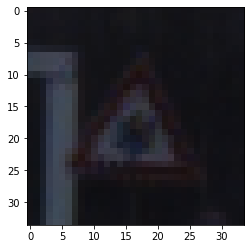

True :30
predicted:11.0

I think that belongs to class: 11.0


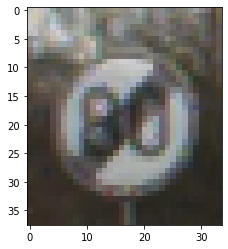

True :6
predicted:6.0

I think that belongs to class: 6.0


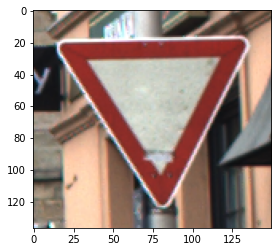

True :13
predicted:13.0

I think that belongs to class: 13.0


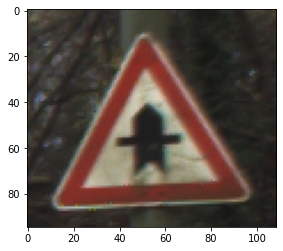

True :11
predicted:11.0

I think that belongs to class: 11.0


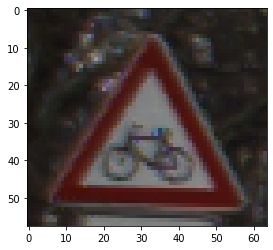

True :29
predicted:29.0

I think that belongs to class: 29.0


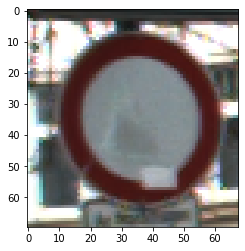

True :15
predicted:15.0

I think that belongs to class: 15.0


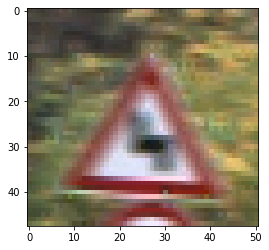

True :21
predicted:21.0

I think that belongs to class: 21.0


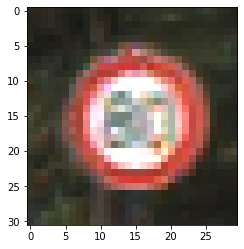

True :5
predicted:5.0

I think that belongs to class: 5.0


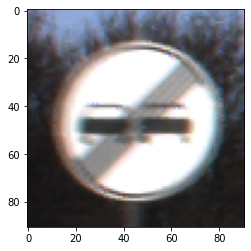

True :41
predicted:41.0

I think that belongs to class: 41.0


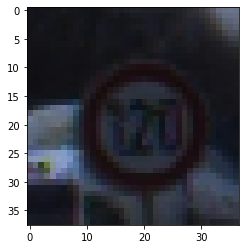

True :8
predicted:8.0

I think that belongs to class: 8.0


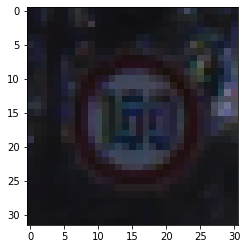

True :7
predicted:8.0

I think that belongs to class: 8.0


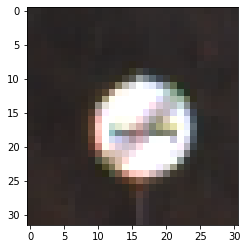

True :41
predicted:5.0

I think that belongs to class: 5.0


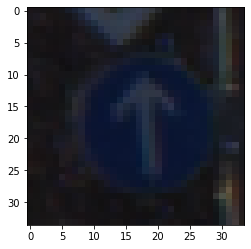

True :35
predicted:35.0

I think that belongs to class: 35.0


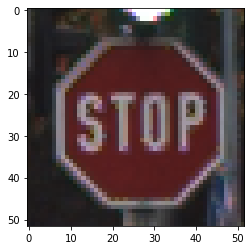

True :14
predicted:14.0

I think that belongs to class: 14.0


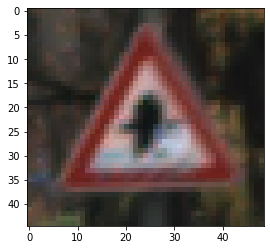

True :11
predicted:11.0

I think that belongs to class: 11.0


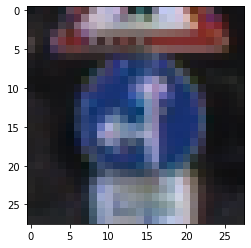

True :37
predicted:37.0

I think that belongs to class: 37.0


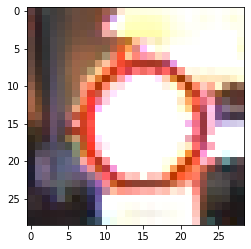

True :15
predicted:15.0

I think that belongs to class: 15.0


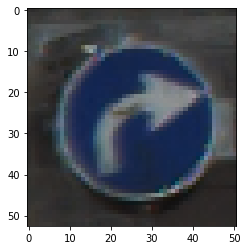

True :33
predicted:33.0

I think that belongs to class: 33.0


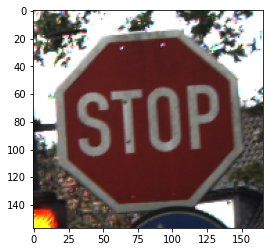

True :14
predicted:14.0

I think that belongs to class: 14.0


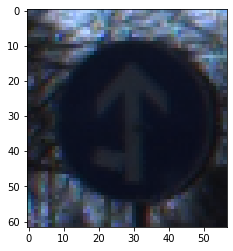

True :35
predicted:35.0

I think that belongs to class: 35.0


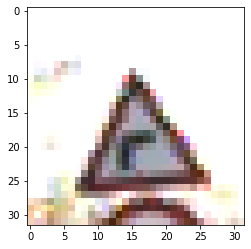

True :20
predicted:20.0

I think that belongs to class: 20.0


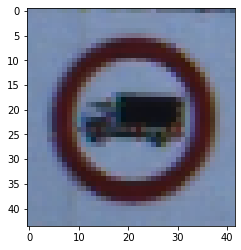

True :16
predicted:16.0

I think that belongs to class: 16.0


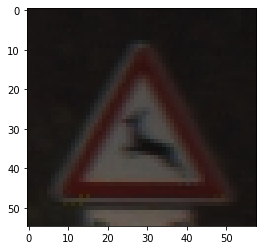

True :31
predicted:31.0

I think that belongs to class: 31.0


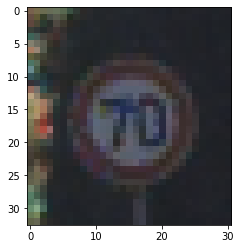

True :4
predicted:4.0

I think that belongs to class: 4.0


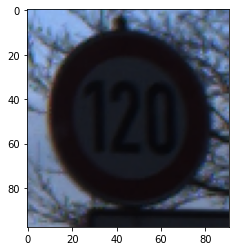

True :8
predicted:8.0

I think that belongs to class: 8.0


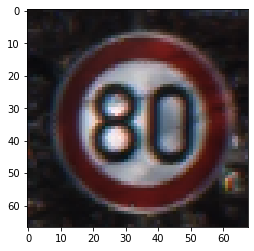

True :5
predicted:5.0

I think that belongs to class: 5.0


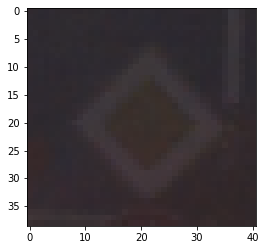

True :12
predicted:12.0

I think that belongs to class: 12.0


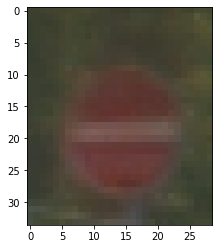

True :17
predicted:17.0

I think that belongs to class: 17.0


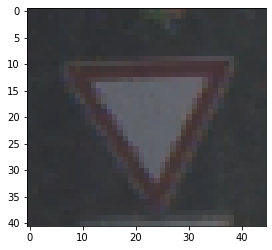

True :13
predicted:13.0

I think that belongs to class: 13.0


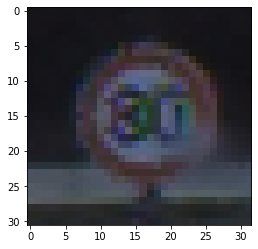

True :5
predicted:5.0

I think that belongs to class: 5.0


In [59]:
for i in range(30):
    testing_on_data()